In [7]:
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

%run shallowCNN.ipynb
%run train_model.ipynb
%run data_handler.ipynb


kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

#This is my 5-fold validation loop :D
def cross_validation_loop_feature_extraction(interval = "full", bias=True, LR = 0.001, epochs = 50, batch_size = 4, dropout = 0.5):
    filename = "results/transfer_learning_shallow.txt"

    fil = open(filename, "a")
    fil.write("Experiment done on model {0}. \n Learning rate: {1} \n Optimizer: {2} \n Loss function: {3} \n Epochs: {6}, Batch size: {7}, Bias: {8} Dropout: {9}\n Experiments run on {4} interval with frequency {5} Hz on the data. Feature extraction."
    .format("shallowCNN", LR, "Adam", "NLLLoss", interval, 254, epochs, batch_size, bias, dropout))
    fil.close()

    saved_models = []

    for subject_nr in range(1,11):
        subject_models = []
        print("Loading subject ", subject_nr)
        data, description = load_subject(subject_nr)
        data, description = get_innerspeech(data, description)
        labels = extract_labels(description)

        train_accuracies = []
        val_accuracies = []
        test_accuracies = []

        i = 0
        for train_index, test_index in kf.split(data, labels, labels):
            print("### Fold {0} ###".format(i))

            # New model
            model = ShallowCNN(hz = 254, interval = interval, bias = bias, dropout = 0.001).float().to(device)
            # Load the pretrained model
            load_model(model, "pretrained_ShallowCNN_subject{0}".format(subject_nr))
            # freeze early layers, all conv.
            model.tempconv.requires_grad = False
            model.spatconv.requires_grad = False
            model.batchnorm.requires_grad = False
            model.dropout.requires_grad = False


            loss_func = nn.NLLLoss()
            op = optim.Adam(params = model.parameters(), lr = LR)

            # Choose train+val data/labels
            train_da=data[train_index]
            train_la=labels[train_index]
            # Choose test data/labels
            test_data=data[test_index]
            test_labels=labels[test_index]

            # Split train into train and val
            train_data, val_data, train_labels, val_labels = train_test_split(train_da, train_la, test_size = 0.25, random_state = None, shuffle = True, stratify = train_la)
            train_data, val_data, test_data, train_labels, val_labels, test_labels = to_device(train_data, val_data, test_data, train_labels, val_labels, test_labels, device)
            # Train loop
            train_model(model, train_data = train_data, train_labels = train_labels, val_data = val_data, val_labels = val_labels, 
                        epochs = epochs, batch_size = batch_size, loss_func = loss_func, optimizer = op)
            # Save model
            subject_models.append(model)
            i += 1
            # Save accuracies
            train_accuracies.append(accuracy_check(model, train_data, train_labels))
            val_accuracies.append(accuracy_check(model, val_data, val_labels))
            test_accuracies.append(accuracy_check(model, test_data, test_labels))
            cf = get_conf_matrix(model, test_data, test_labels)
            plt.show(sns.heatmap(cf, annot=True))
        
        saved_models.append(subject_models)
        # Write results for subject to file
        fil = open(filename, "a")
        fil.write("\n\nResults for subject {0}.\n".format(subject_nr))
        fil.write("Train accuracies from 5 folds:\n")
        for acc in train_accuracies:
            fil.write("{0}, ".format(acc))
        fil.write("\n")
        fil.write("Validation accuracies from 5 folds:\n")
        for acc in val_accuracies:
            fil.write("{0}, ".format(acc))
        fil.write("\n")
        fil.write("Test accuracies from 5 folds:\n")
        for acc in test_accuracies:
            fil.write("{0}, ".format(acc))
        fil.write("\n")

        fil.write("Avg train acc: {0}, Avg validation acc: {1}, Avg test acc: {2}, ".format(sum(train_accuracies)/5, sum(val_accuracies)/5, sum(test_accuracies)/5))
        fil.write("\n\n#####################################\n\n")
        fil.close()
    return saved_models



def cross_validation_loop_fine_tune(interval="full", bias=True, LR = 0.001, epochs = 50, batch_size = 4, dropout = 0.5):
    filename = "results/transfer_learning_shallow.txt"

    fil = open(filename, "a")
    fil.write("Experiment done on model {0}. \n Learning rate: {1} \n Optimizer: {2} \n Loss function: {3} \n Epochs: {6}, Batch size: {7}, Bias: {8} Dropout: {9}\n Experiments run on {4} interval with frequency {5} Hz on the data. Fine tuning."
    .format("shallowCNN", LR, "Adam", "NLLLoss", interval, 254, epochs, batch_size, bias, dropout))
    fil.close()

    saved_models = []

    for subject_nr in range(1,11):
        subject_models = []
        print("Loading subject ", subject_nr)
        data, description = load_subject(subject_nr)
        data, description = get_innerspeech(data, description)
        labels = extract_labels(description)

        train_accuracies = []
        val_accuracies = []
        test_accuracies = []

        i = 0
        for train_index, test_index in kf.split(data, labels, labels):
            print("### Fold {0} ###".format(i))

            # New model
            model = ShallowCNN(hz = 254, interval = interval, bias = bias, dropout = 0.001).float().to(device)
            # Load the pretrained model
            load_model(model, "pretrained_ShallowCNN_subject{0}".format(subject_nr))
            # freeze classifier layer.
            model.classifier.requires_grad = False


            loss_func = nn.NLLLoss()
            op = optim.Adam(params = model.parameters(), lr = LR)

            # Choose train+val data/labels
            train_da=data[train_index]
            train_la=labels[train_index]
            # Choose test data/labels
            test_data=data[test_index]
            test_labels=labels[test_index]

            # Split train into train and val
            train_data, val_data, train_labels, val_labels = train_test_split(train_da, train_la, test_size = 0.25, random_state = None, shuffle = True, stratify = train_la)
            train_data, val_data, test_data, train_labels, val_labels, test_labels = to_device(train_data, val_data, test_data, train_labels, val_labels, test_labels, device)
            # Train loop
            train_model(model, train_data = train_data, train_labels = train_labels, val_data = val_data, val_labels = val_labels, 
                        epochs = epochs, batch_size = batch_size, loss_func = loss_func, optimizer = op)
            # Save model
            subject_models.append(model)
            i += 1
            # Save accuracies
            train_accuracies.append(accuracy_check(model, train_data, train_labels))
            val_accuracies.append(accuracy_check(model, val_data, val_labels))
            test_accuracies.append(accuracy_check(model, test_data, test_labels))
            cf = get_conf_matrix(model, test_data, test_labels)
            plt.show(sns.heatmap(cf, annot=True))
        
        saved_models.append(subject_models)
        # Write results for subject to file
        fil = open(filename, "a")
        fil.write("\n\nResults for subject {0}.\n".format(subject_nr))
        fil.write("Train accuracies from 5 folds:\n")
        for acc in train_accuracies:
            fil.write("{0}, ".format(acc))
        fil.write("\n")
        fil.write("Validation accuracies from 5 folds:\n")
        for acc in val_accuracies:
            fil.write("{0}, ".format(acc))
        fil.write("\n")
        fil.write("Test accuracies from 5 folds:\n")
        for acc in test_accuracies:
            fil.write("{0}, ".format(acc))
        fil.write("\n")

        fil.write("Avg train acc: {0}, Avg validation acc: {1}, Avg test acc: {2}, ".format(sum(train_accuracies)/5, sum(val_accuracies)/5, sum(test_accuracies)/5))
        fil.write("\n\n#####################################\n\n")
        fil.close()
    return saved_models
    

Loading subject  1
### Fold 0 ###


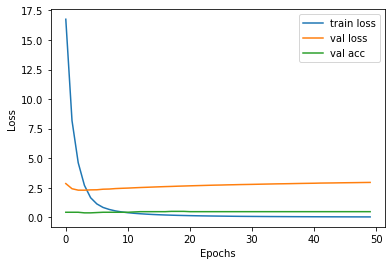

Best model found on epoch:  19


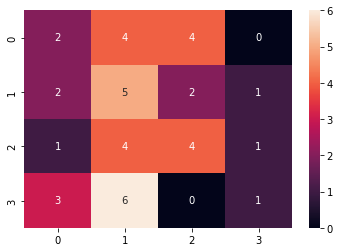

### Fold 1 ###


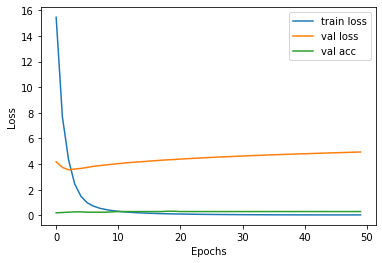

Best model found on epoch:  19


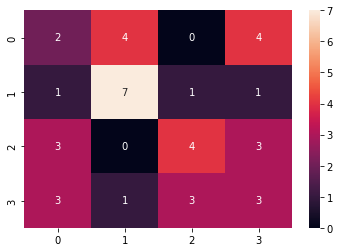

### Fold 2 ###


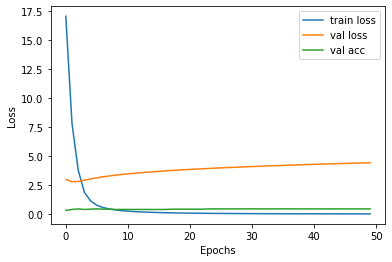

Best model found on epoch:  49


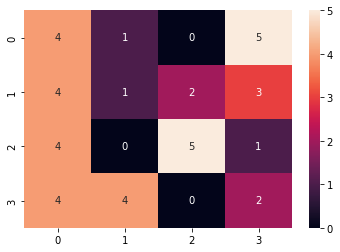

### Fold 3 ###


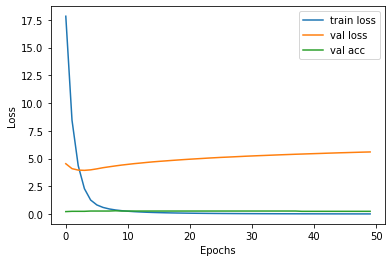

Best model found on epoch:  8


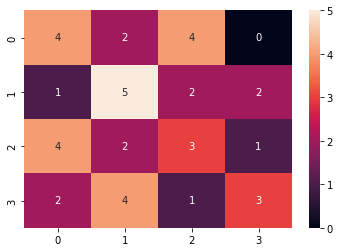

### Fold 4 ###


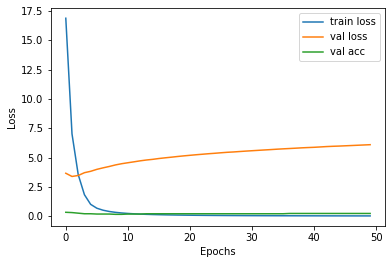

Best model found on epoch:  0


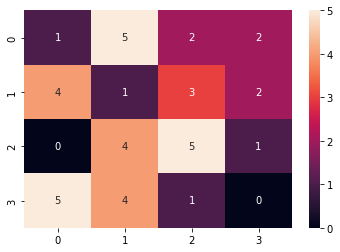

Loading subject  2
### Fold 0 ###


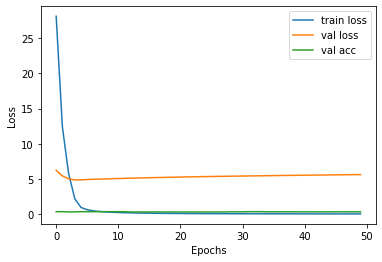

Best model found on epoch:  33


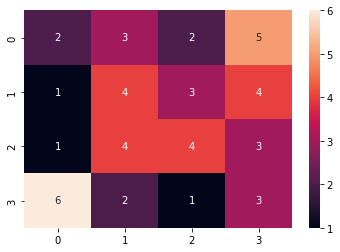

### Fold 1 ###


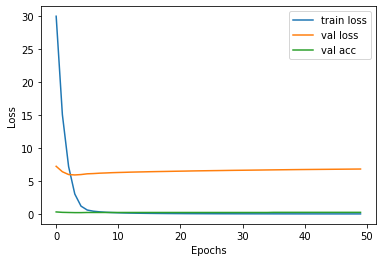

Best model found on epoch:  0


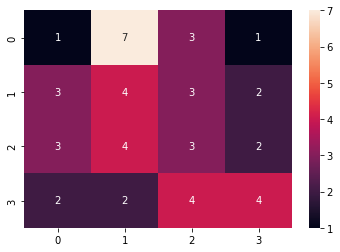

### Fold 2 ###


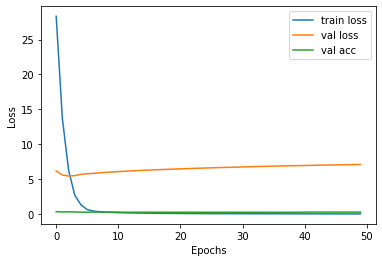

Best model found on epoch:  0


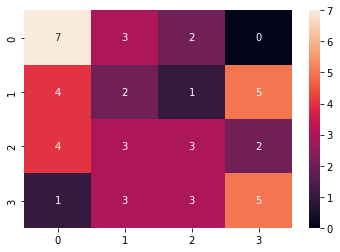

### Fold 3 ###


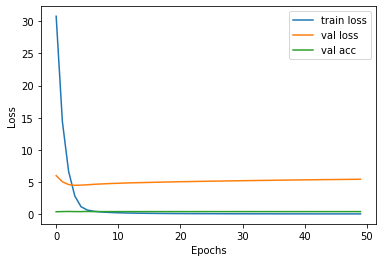

Best model found on epoch:  5


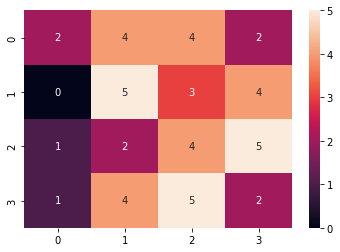

### Fold 4 ###


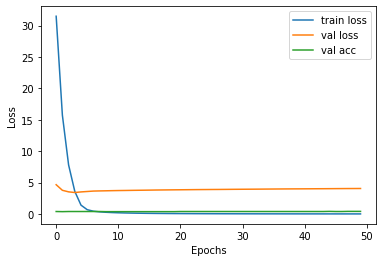

Best model found on epoch:  49


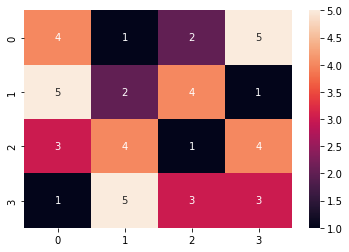

Loading subject  3
### Fold 0 ###


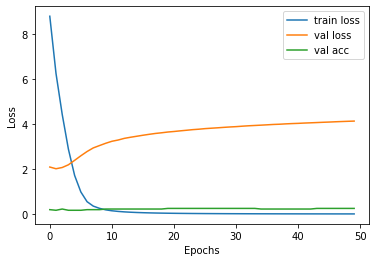

Best model found on epoch:  49


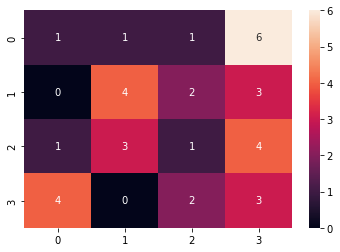

### Fold 1 ###


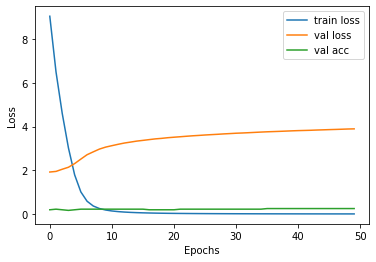

Best model found on epoch:  49


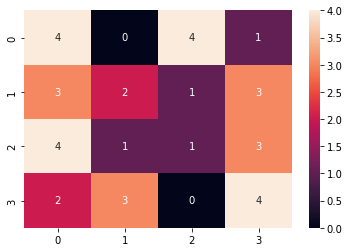

### Fold 2 ###


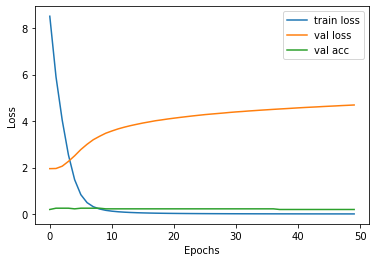

Best model found on epoch:  8


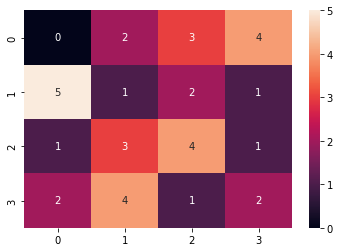

### Fold 3 ###


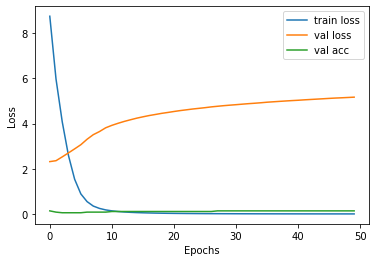

Best model found on epoch:  49


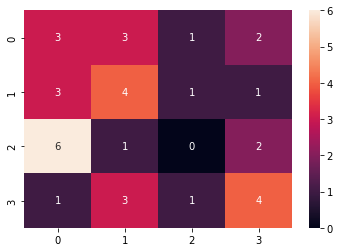

### Fold 4 ###


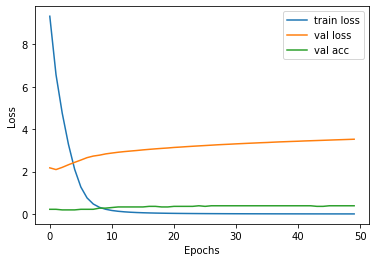

Best model found on epoch:  49


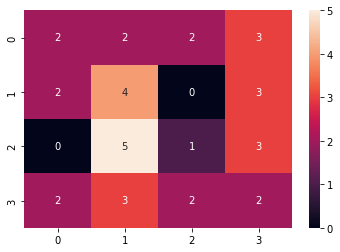

Loading subject  4
### Fold 0 ###


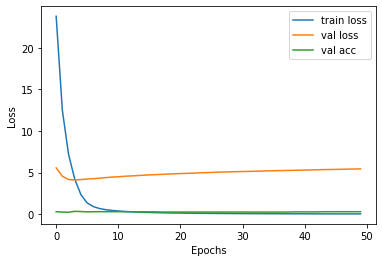

Best model found on epoch:  3


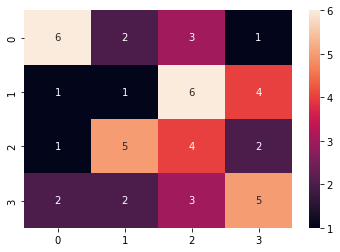

### Fold 1 ###


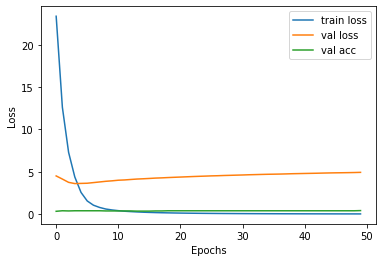

Best model found on epoch:  49


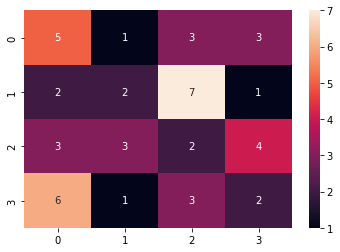

### Fold 2 ###


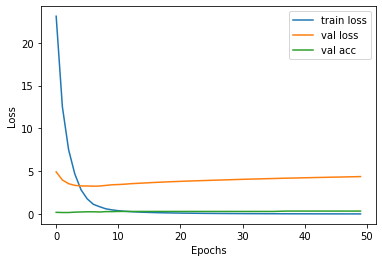

Best model found on epoch:  49


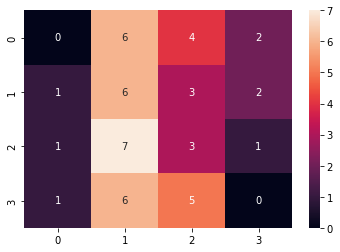

### Fold 3 ###


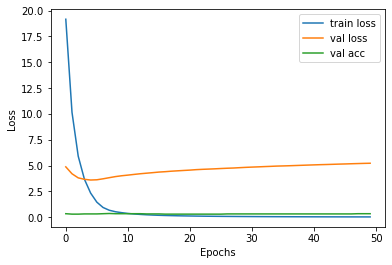

Best model found on epoch:  7


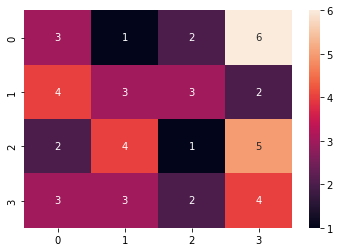

### Fold 4 ###


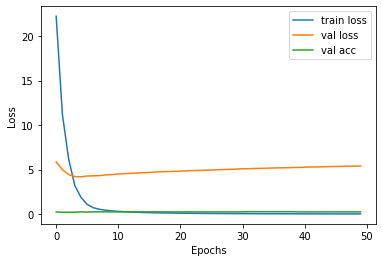

Best model found on epoch:  38


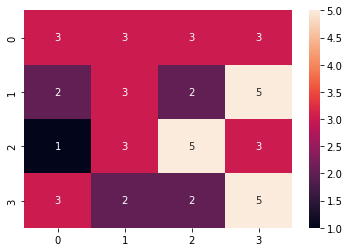

Loading subject  5
### Fold 0 ###


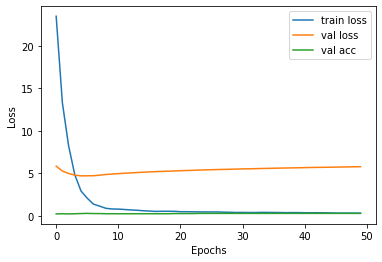

Best model found on epoch:  49


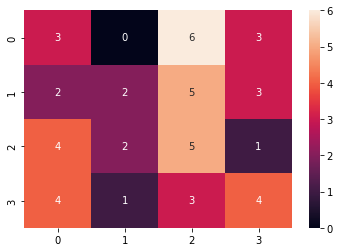

### Fold 1 ###


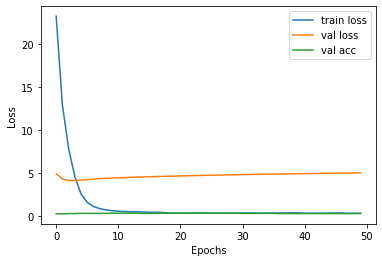

Best model found on epoch:  29


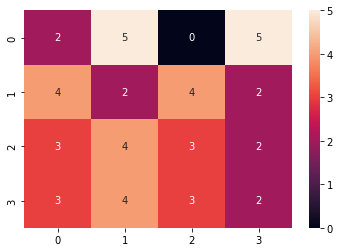

### Fold 2 ###


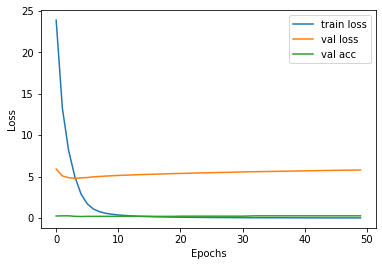

Best model found on epoch:  49


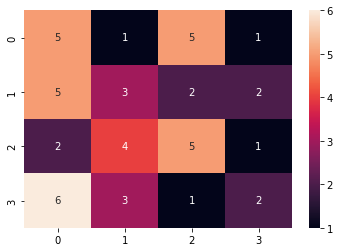

### Fold 3 ###


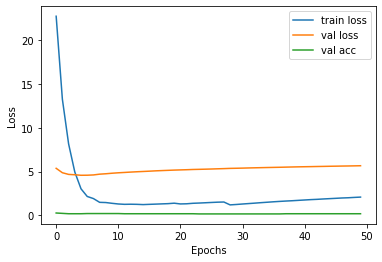

Best model found on epoch:  0


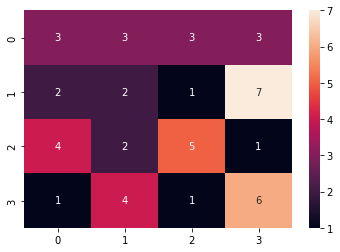

### Fold 4 ###


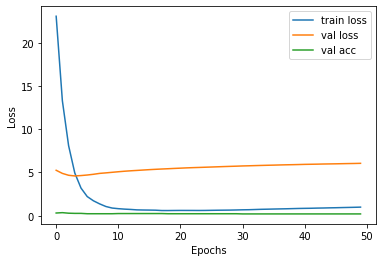

Best model found on epoch:  1


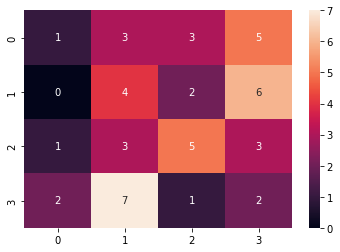

Loading subject  6
### Fold 0 ###


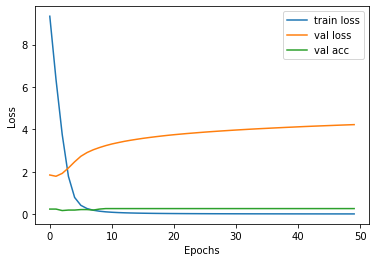

Best model found on epoch:  49


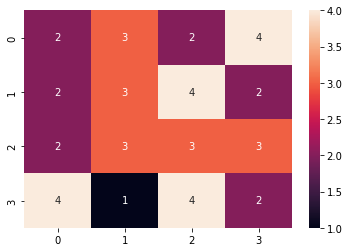

### Fold 1 ###


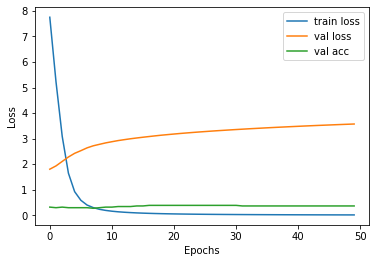

Best model found on epoch:  30


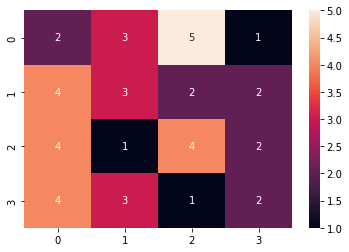

### Fold 2 ###


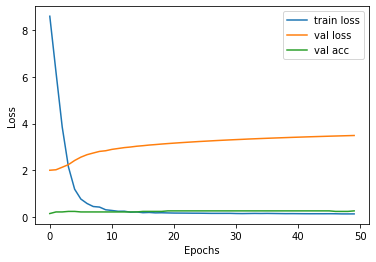

Best model found on epoch:  49


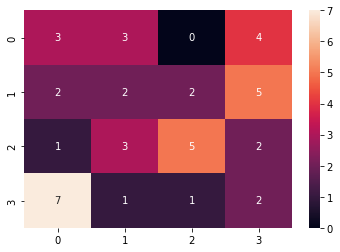

### Fold 3 ###


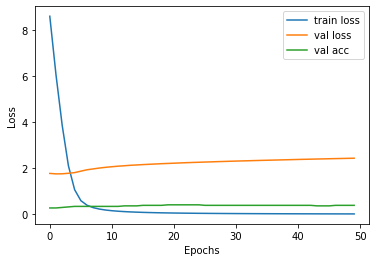

Best model found on epoch:  24


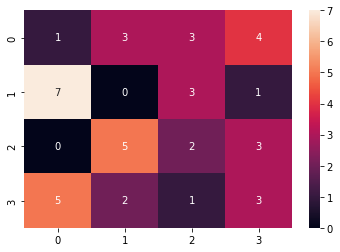

### Fold 4 ###


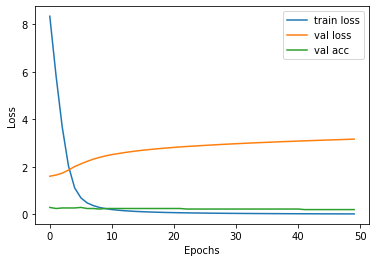

Best model found on epoch:  5


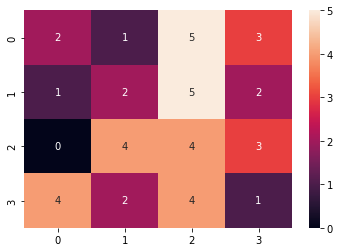

Loading subject  7
### Fold 0 ###


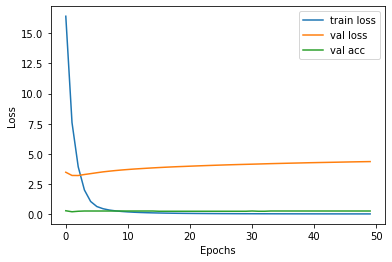

Best model found on epoch:  0


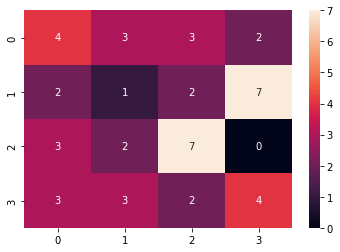

### Fold 1 ###


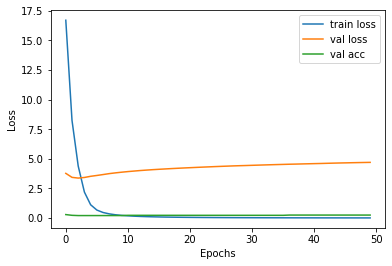

Best model found on epoch:  0


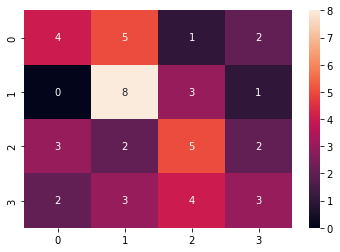

### Fold 2 ###


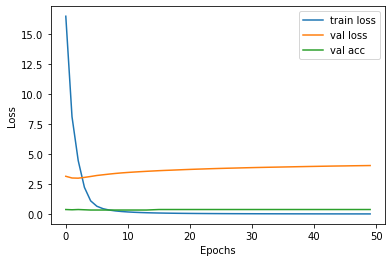

Best model found on epoch:  49


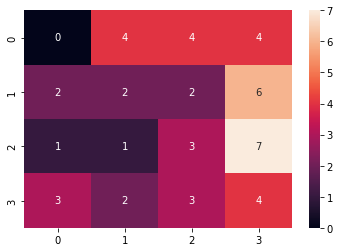

### Fold 3 ###


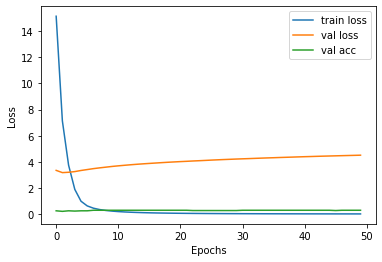

Best model found on epoch:  49


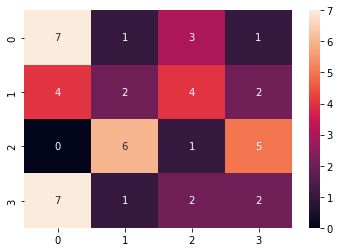

### Fold 4 ###


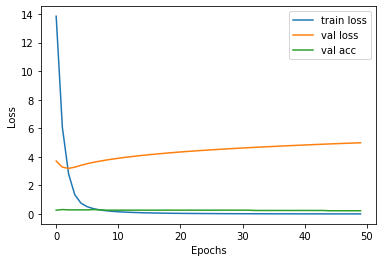

Best model found on epoch:  6


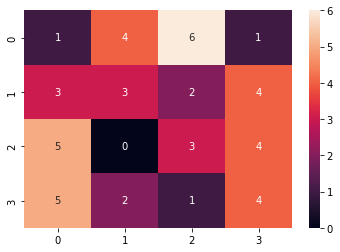

Loading subject  8
### Fold 0 ###


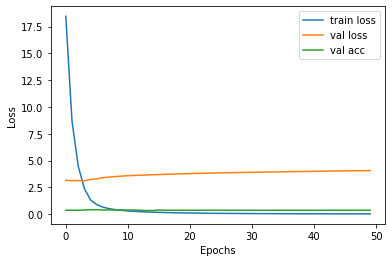

Best model found on epoch:  5


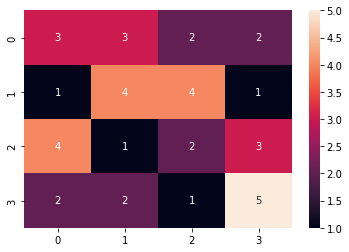

### Fold 1 ###


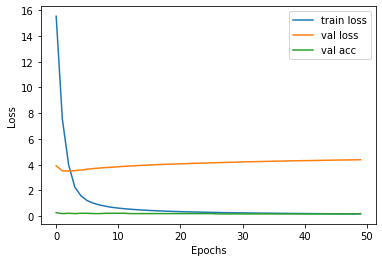

Best model found on epoch:  0


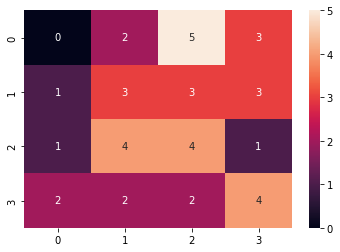

### Fold 2 ###


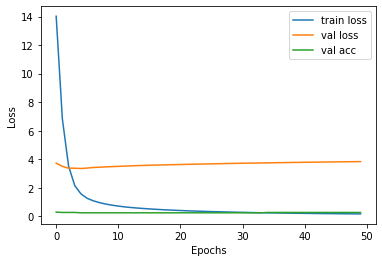

Best model found on epoch:  0


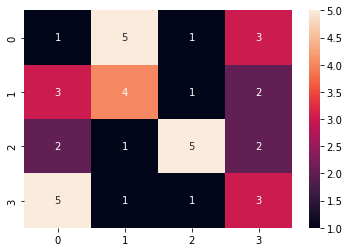

### Fold 3 ###


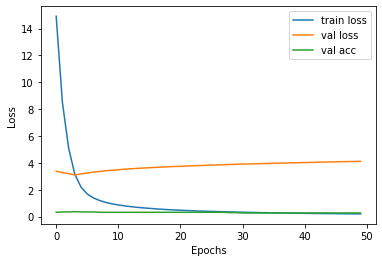

Best model found on epoch:  3


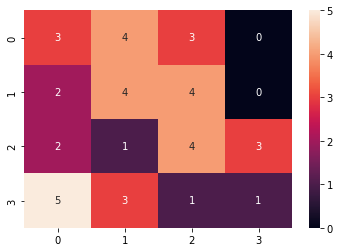

### Fold 4 ###


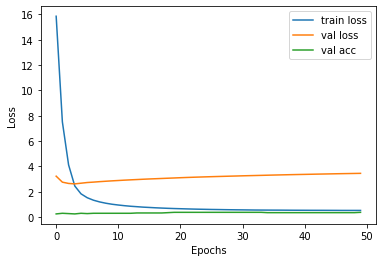

Best model found on epoch:  49


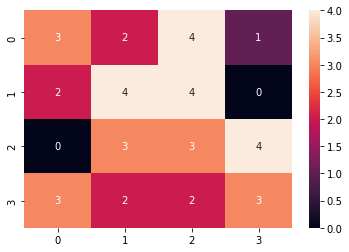

Loading subject  9
### Fold 0 ###


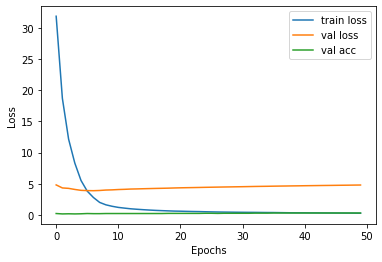

Best model found on epoch:  49


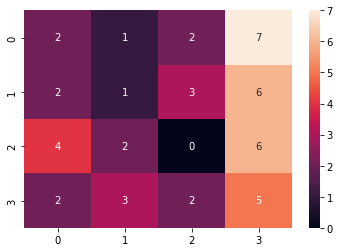

### Fold 1 ###


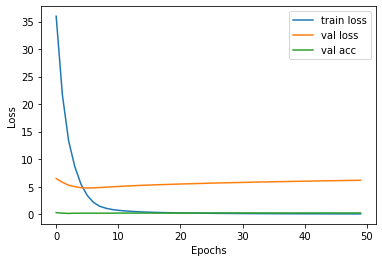

Best model found on epoch:  0


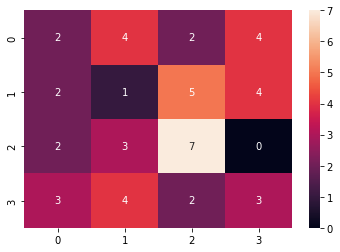

### Fold 2 ###


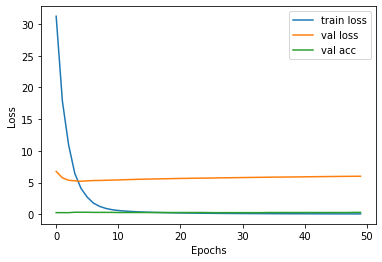

Best model found on epoch:  5


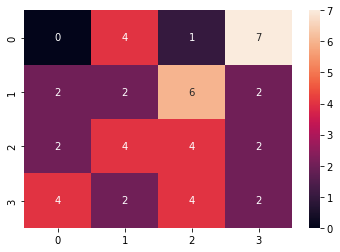

### Fold 3 ###


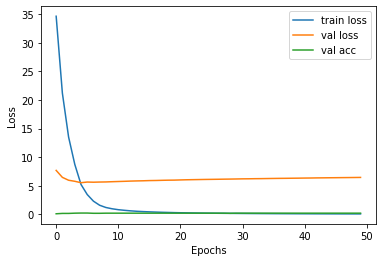

Best model found on epoch:  5


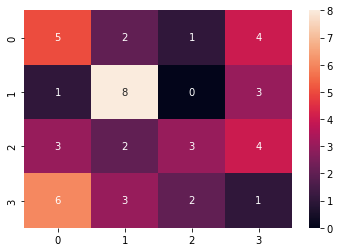

### Fold 4 ###


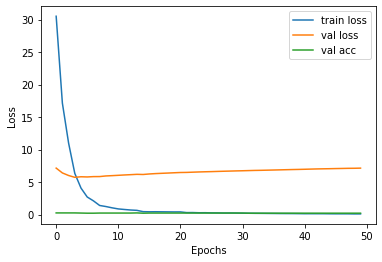

Best model found on epoch:  13


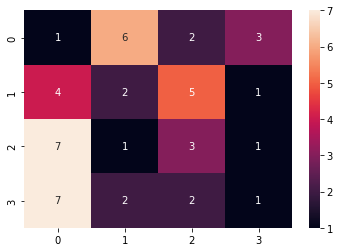

Loading subject  10
### Fold 0 ###


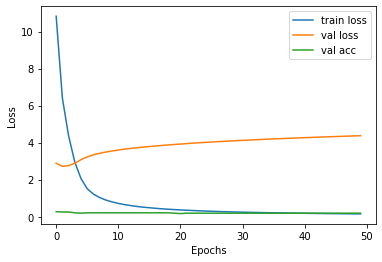

Best model found on epoch:  0


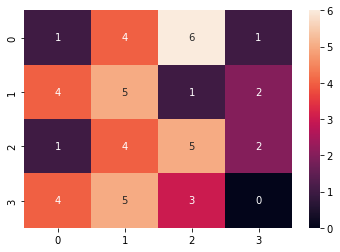

### Fold 1 ###


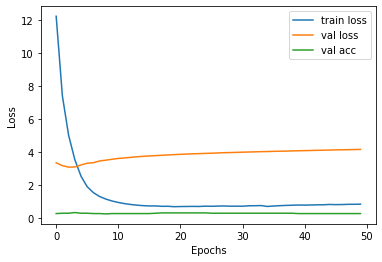

Best model found on epoch:  3


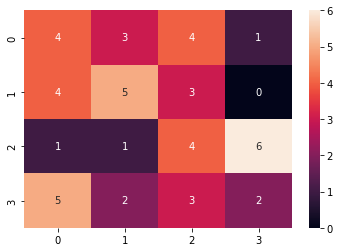

### Fold 2 ###


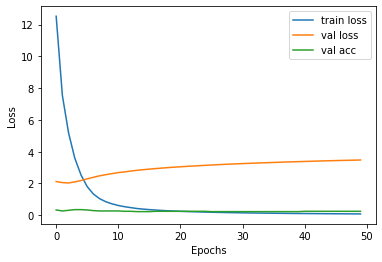

Best model found on epoch:  4


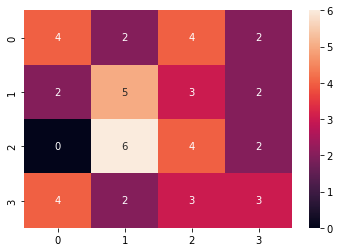

### Fold 3 ###


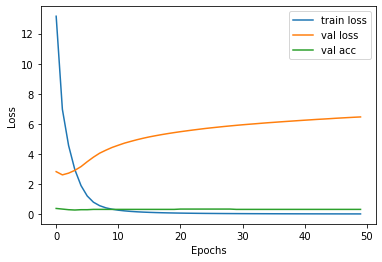

Best model found on epoch:  0


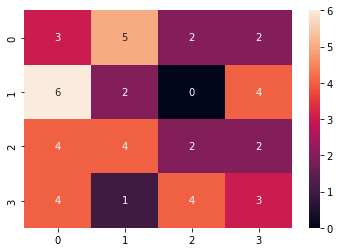

### Fold 4 ###


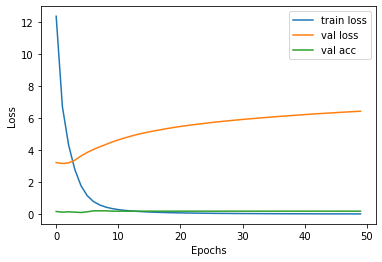

Best model found on epoch:  8


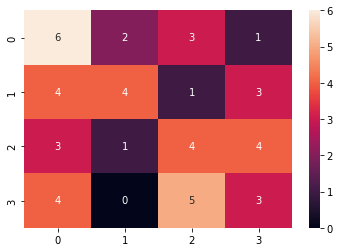

[[ShallowCNN(
    (tempconv): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1), bias=False)
    (spatconv): Conv2d(40, 40, kernel_size=(128, 1), stride=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(40, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0)
    (dropout): Dropout(p=0.001, inplace=False)
    (meanpool): AvgPool2d(kernel_size=(1, 75), stride=(1, 15), padding=0)
    (classifier): Linear(in_features=2840, out_features=4, bias=True)
    (softmax): LogSoftmax(dim=1)
  ),
  ShallowCNN(
    (tempconv): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1), bias=False)
    (spatconv): Conv2d(40, 40, kernel_size=(128, 1), stride=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(40, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0)
    (dropout): Dropout(p=0.001, inplace=False)
    (meanpool): AvgPool2d(kernel_size=(1, 75), stride=(1, 15), padding=0)
    (classifier): Linear(in_features=2840, out_features=4, b

In [5]:
cross_validation_loop_feature_extraction()

Loading subject  1
### Fold 0 ###


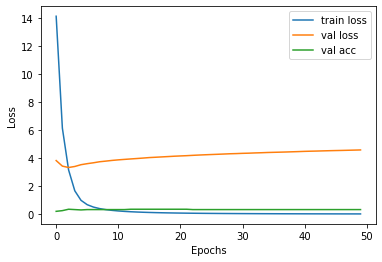

Best model found on epoch:  21


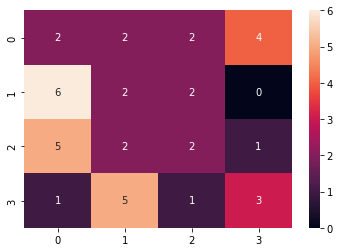

### Fold 1 ###


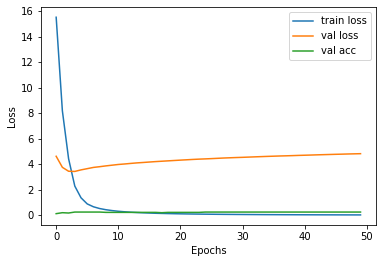

Best model found on epoch:  49


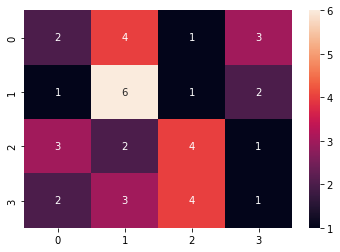

### Fold 2 ###


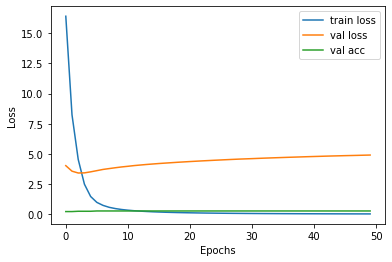

Best model found on epoch:  49


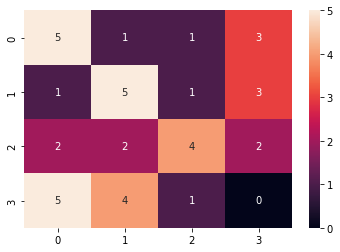

### Fold 3 ###


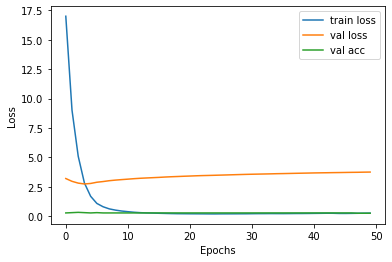

Best model found on epoch:  2


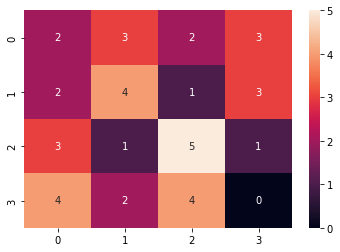

### Fold 4 ###


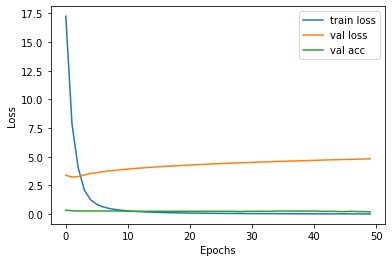

Best model found on epoch:  0


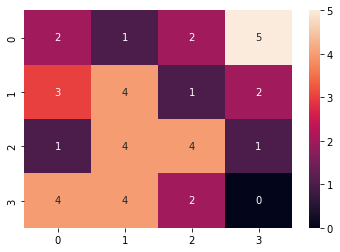

Loading subject  2
### Fold 0 ###


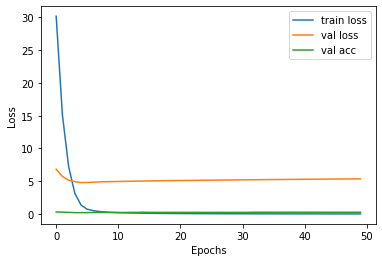

Best model found on epoch:  0


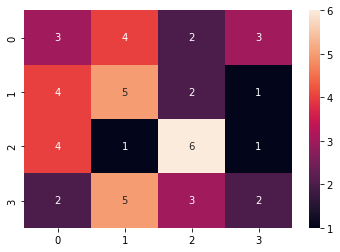

### Fold 1 ###


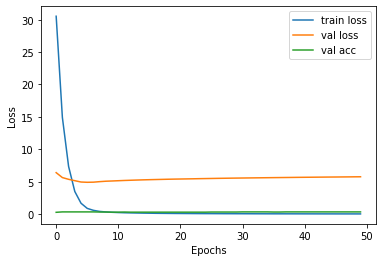

Best model found on epoch:  49


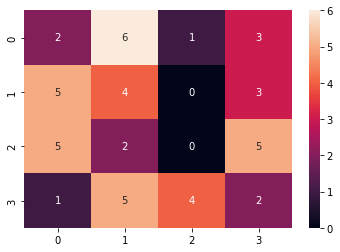

### Fold 2 ###


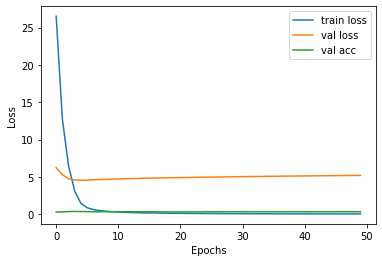

Best model found on epoch:  3


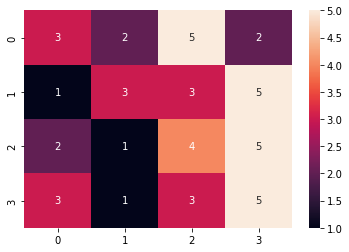

### Fold 3 ###


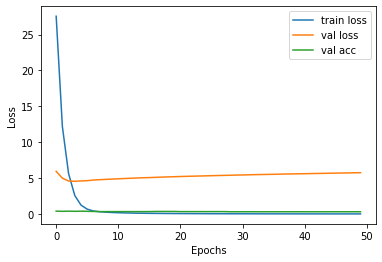

Best model found on epoch:  4


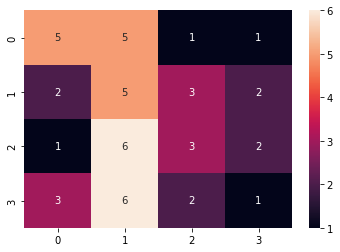

### Fold 4 ###


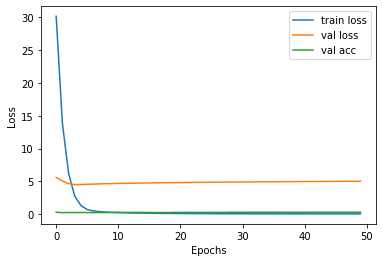

Best model found on epoch:  49


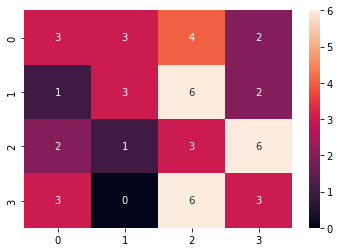

Loading subject  3
### Fold 0 ###


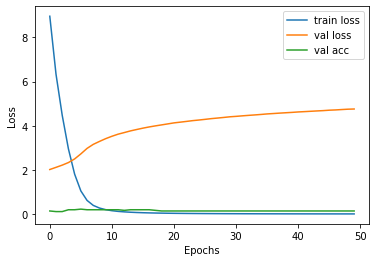

Best model found on epoch:  5


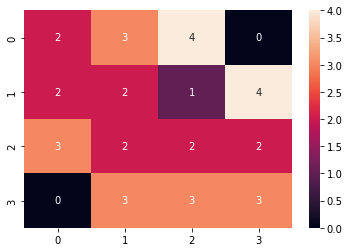

### Fold 1 ###


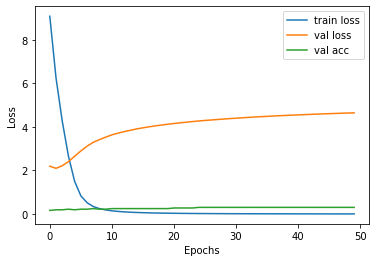

Best model found on epoch:  49


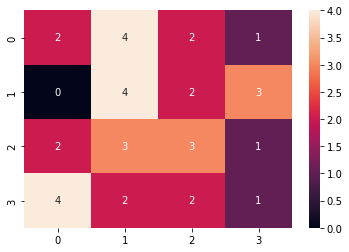

### Fold 2 ###


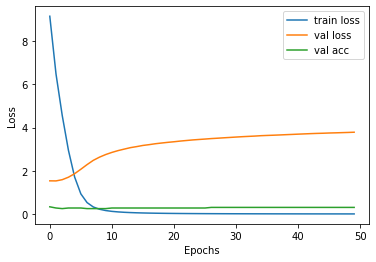

Best model found on epoch:  0


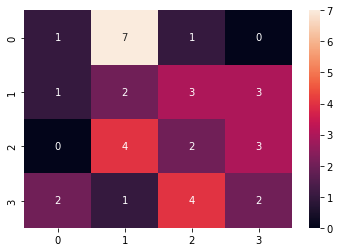

### Fold 3 ###


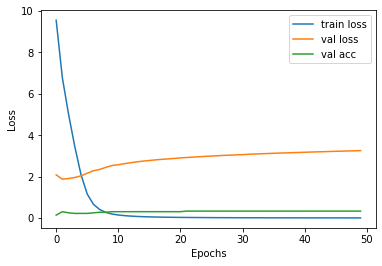

Best model found on epoch:  49


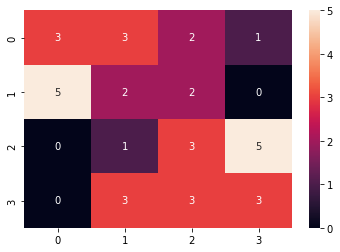

### Fold 4 ###


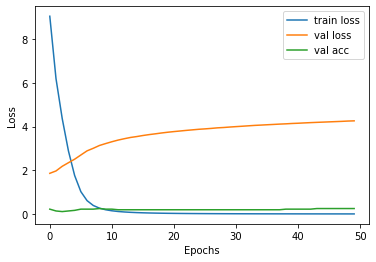

Best model found on epoch:  49


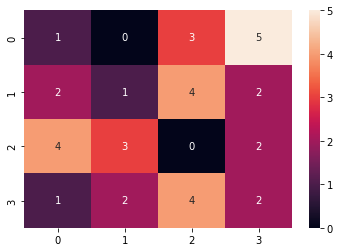

Loading subject  4
### Fold 0 ###


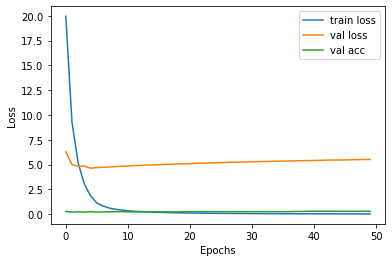

Best model found on epoch:  49


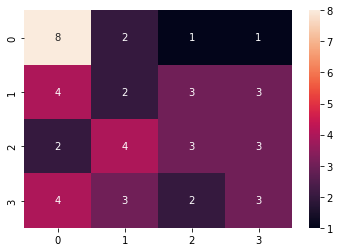

### Fold 1 ###


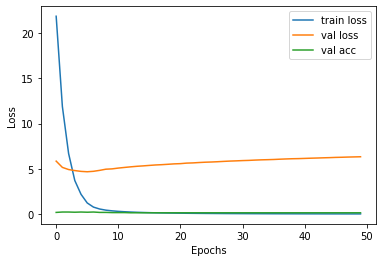

Best model found on epoch:  6


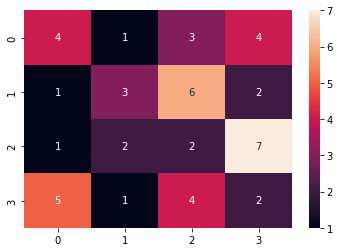

### Fold 2 ###


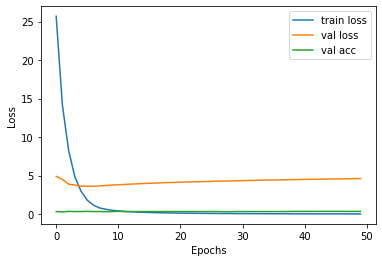

Best model found on epoch:  49


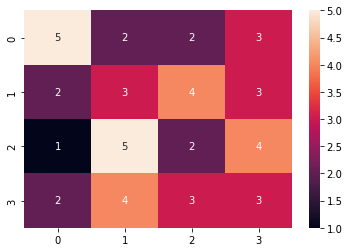

### Fold 3 ###


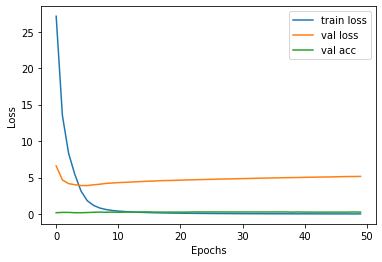

Best model found on epoch:  48


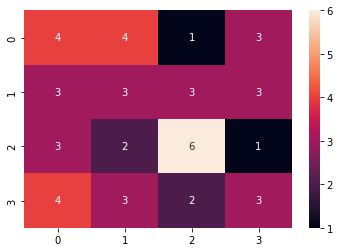

### Fold 4 ###


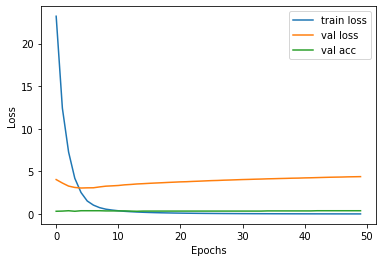

Best model found on epoch:  49


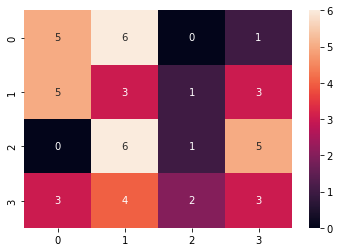

Loading subject  5
### Fold 0 ###


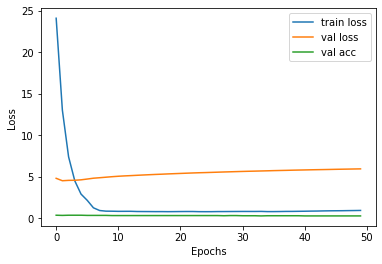

Best model found on epoch:  4


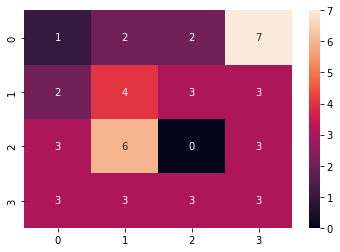

### Fold 1 ###


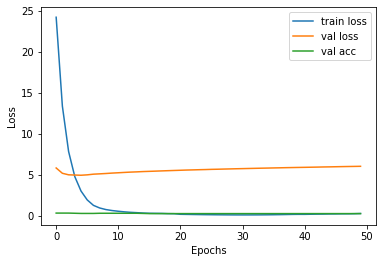

Best model found on epoch:  2


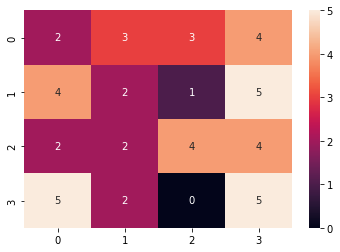

### Fold 2 ###


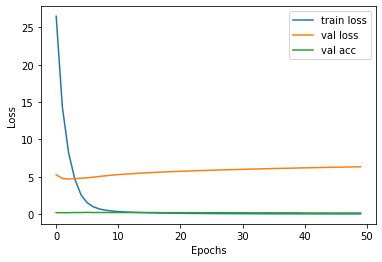

Best model found on epoch:  5


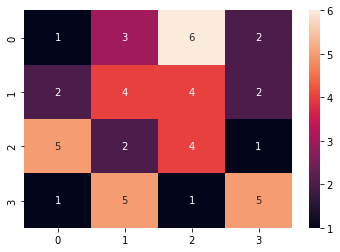

### Fold 3 ###


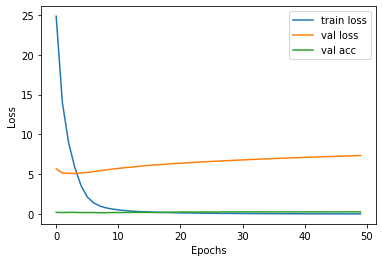

Best model found on epoch:  49


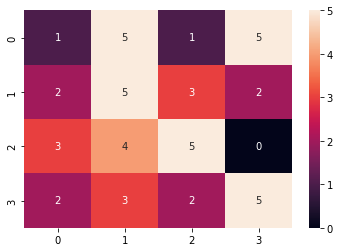

### Fold 4 ###


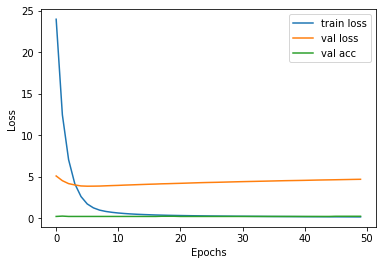

Best model found on epoch:  1


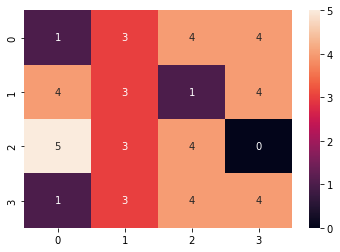

Loading subject  6
### Fold 0 ###


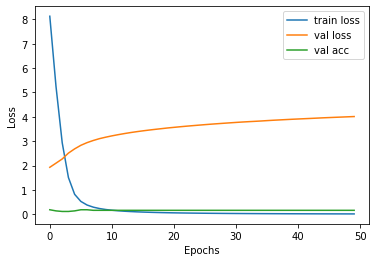

Best model found on epoch:  6


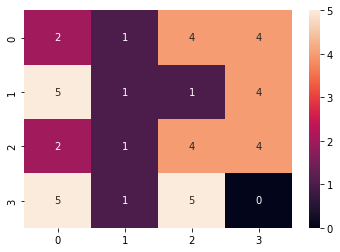

### Fold 1 ###


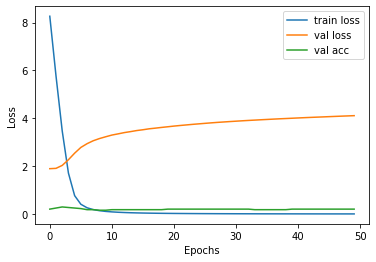

Best model found on epoch:  2


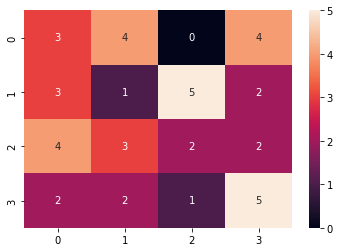

### Fold 2 ###


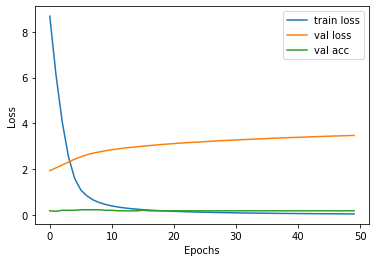

Best model found on epoch:  8


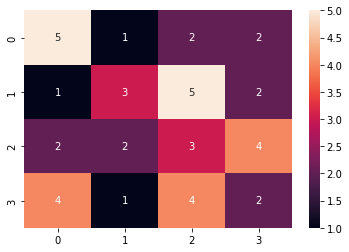

### Fold 3 ###


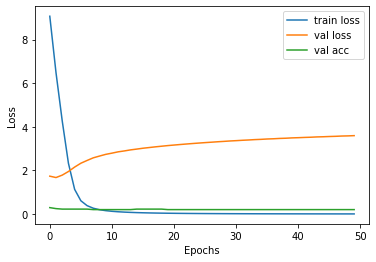

Best model found on epoch:  0


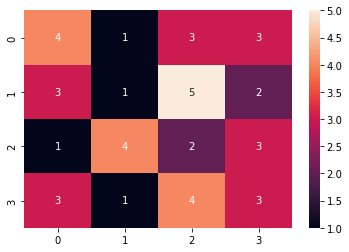

### Fold 4 ###


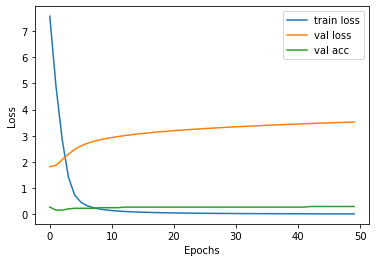

Best model found on epoch:  49


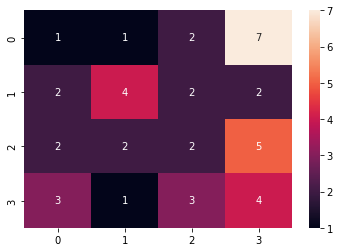

Loading subject  7
### Fold 0 ###


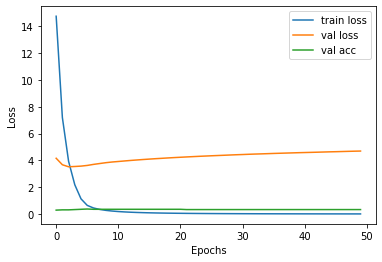

Best model found on epoch:  5


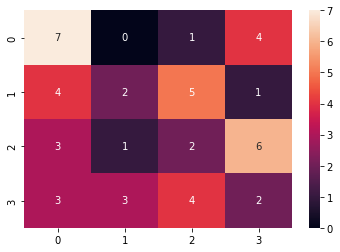

### Fold 1 ###


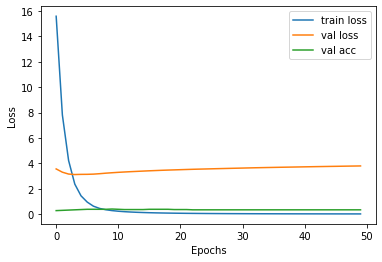

Best model found on epoch:  9


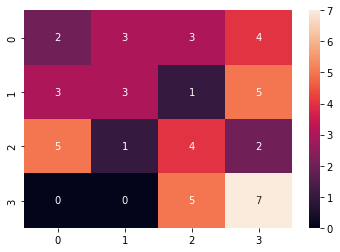

### Fold 2 ###


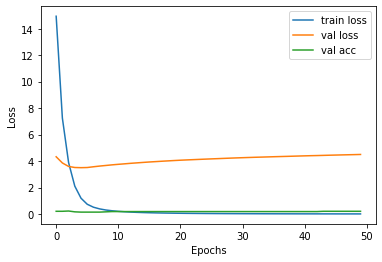

Best model found on epoch:  2


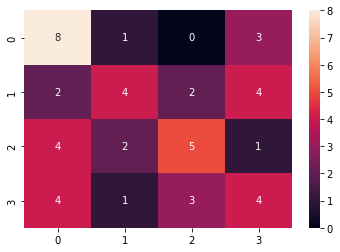

### Fold 3 ###


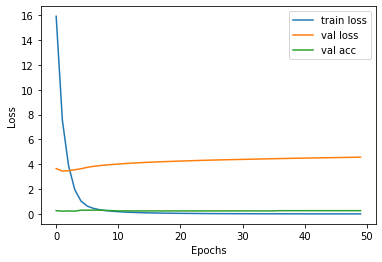

Best model found on epoch:  7


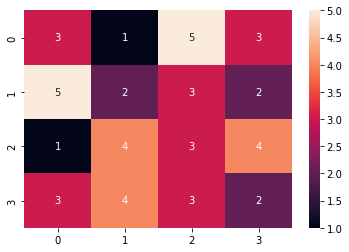

### Fold 4 ###


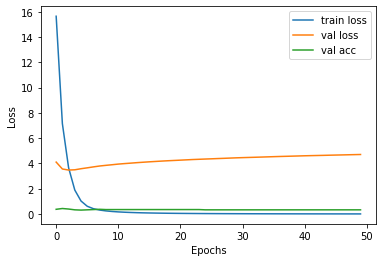

Best model found on epoch:  1


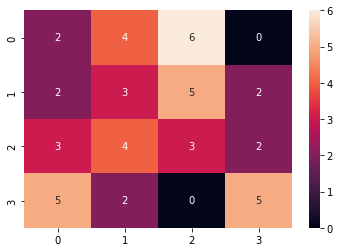

Loading subject  8
### Fold 0 ###


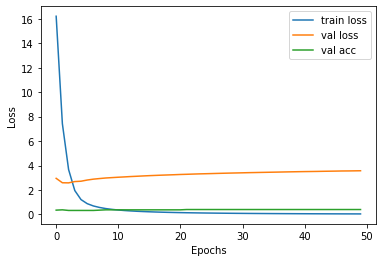

Best model found on epoch:  49


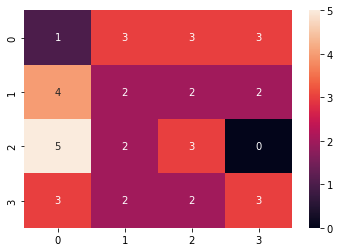

### Fold 1 ###


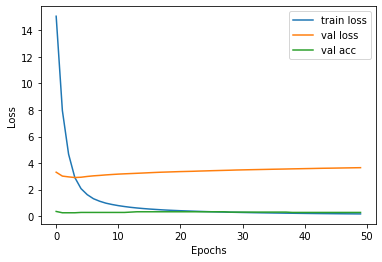

Best model found on epoch:  0


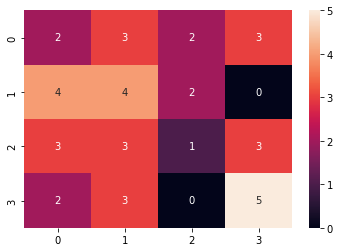

### Fold 2 ###


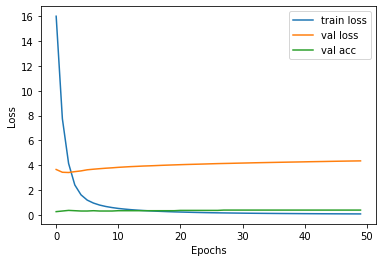

Best model found on epoch:  49


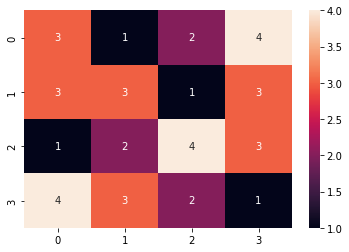

### Fold 3 ###


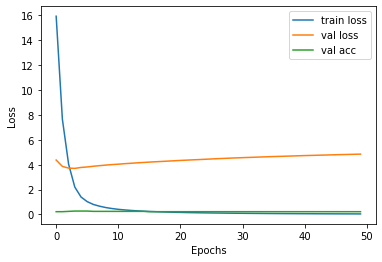

Best model found on epoch:  5


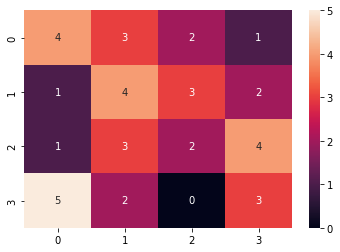

### Fold 4 ###


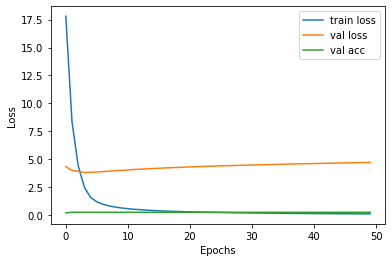

Best model found on epoch:  49


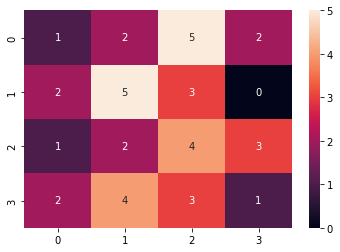

Loading subject  9
### Fold 0 ###


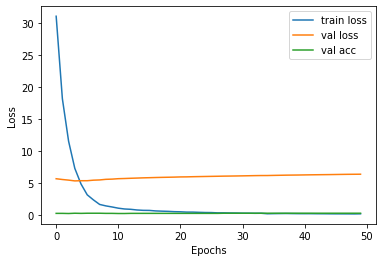

Best model found on epoch:  49


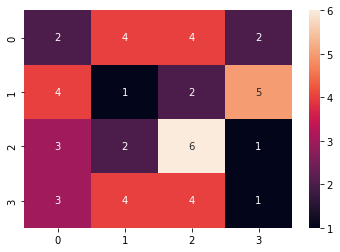

### Fold 1 ###


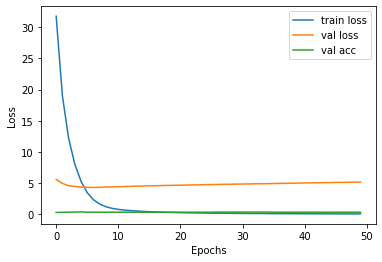

Best model found on epoch:  4


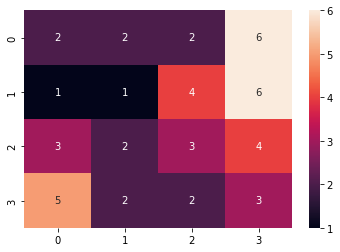

### Fold 2 ###


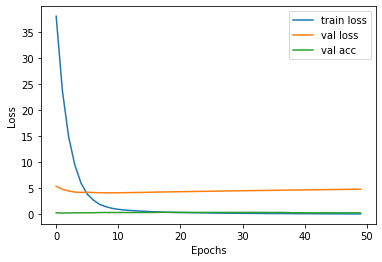

Best model found on epoch:  19


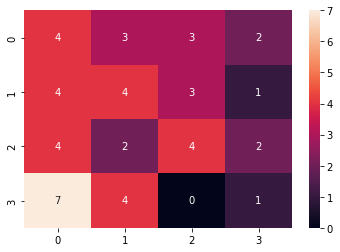

### Fold 3 ###


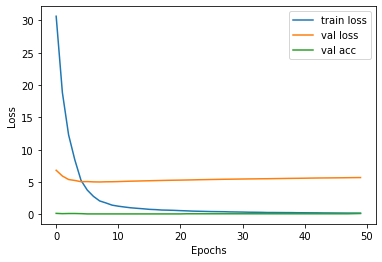

Best model found on epoch:  0


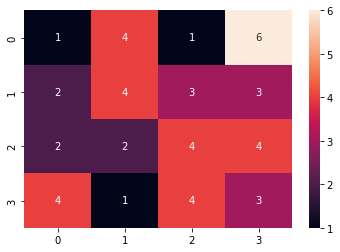

### Fold 4 ###


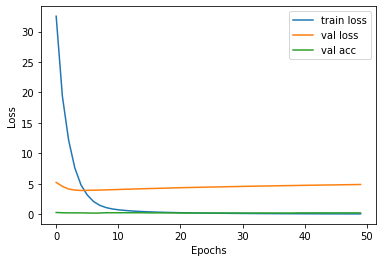

Best model found on epoch:  0


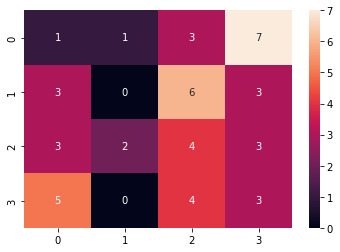

Loading subject  10
### Fold 0 ###


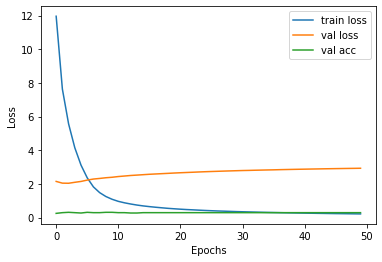

Best model found on epoch:  9


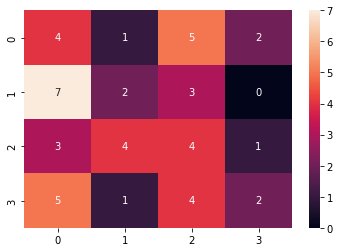

### Fold 1 ###


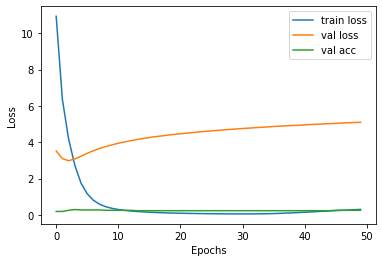

Best model found on epoch:  3


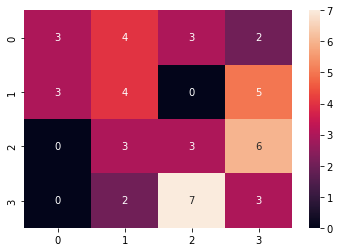

### Fold 2 ###


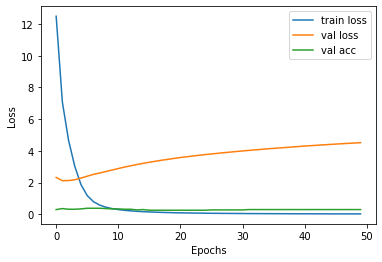

Best model found on epoch:  7


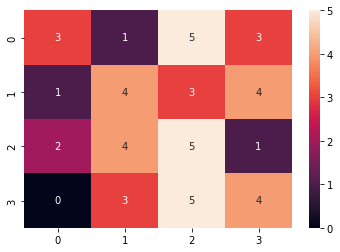

### Fold 3 ###


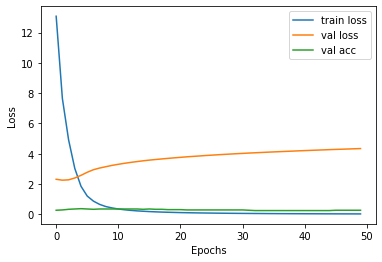

Best model found on epoch:  4


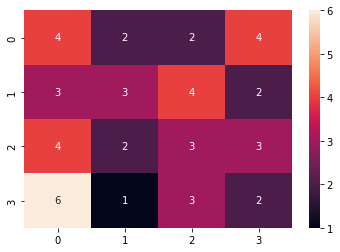

### Fold 4 ###


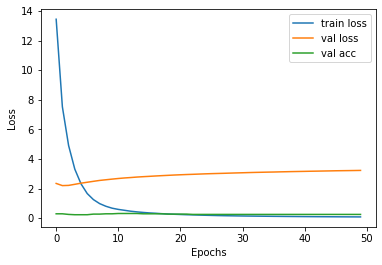

Best model found on epoch:  13


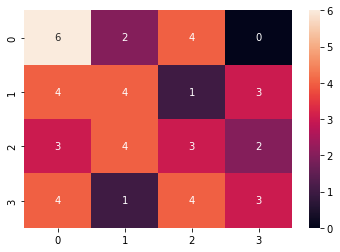

[[ShallowCNN(
    (tempconv): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1), bias=False)
    (spatconv): Conv2d(40, 40, kernel_size=(128, 1), stride=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(40, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0)
    (dropout): Dropout(p=0.001, inplace=False)
    (meanpool): AvgPool2d(kernel_size=(1, 75), stride=(1, 15), padding=0)
    (classifier): Linear(in_features=2840, out_features=4, bias=True)
    (softmax): LogSoftmax(dim=1)
  ),
  ShallowCNN(
    (tempconv): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1), bias=False)
    (spatconv): Conv2d(40, 40, kernel_size=(128, 1), stride=(1, 1), bias=False)
    (batchnorm): BatchNorm2d(40, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (elu): ELU(alpha=1.0)
    (dropout): Dropout(p=0.001, inplace=False)
    (meanpool): AvgPool2d(kernel_size=(1, 75), stride=(1, 15), padding=0)
    (classifier): Linear(in_features=2840, out_features=4, b

In [8]:
cross_validation_loop_fine_tune()